In [37]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

In [35]:
hc = gpd.read_file('./data/healthcare.shp')
hc.head()

,NAME,TYPE,geometry
0,THE CARLE FOUNDATION HOSPITAL,Hospital,POINT (-88.21495 40.11704)
1,THE PAVILION FOUNDATION,Hospital,POINT (-88.25754 40.11771)
2,OSF HEALTHCARE SYSTEM HEART OF MARY MEDICAL CE...,Hospital,POINT (-88.22711 40.11797)
3,URBANA FIRE RESCUE SERVICES - MAIN STATION,EMS,POINT (-88.20452 40.10999)
4,SAVOY FIRE DEPARTMENT,EMS,POINT (-88.25114 40.06293)


In [36]:
cbg = gpd.read_file('./data/census_block_group.shp')
cbg.head()

,STATEFP,COUNTYFP,GEOID,geometry
0,17,019,170190008004,"POLYGON ((-88.25812 40.15652, -88.25810 40.156..."
1,17,019,170190109021,"POLYGON ((-88.31384 40.04801, -88.31383 40.048..."
2,17,019,170190014003,"POLYGON ((-88.24917 40.06616, -88.24917 40.066..."
3,17,019,170190008003,"POLYGON ((-88.27710 40.15771, -88.27705 40.157..."
4,17,019,170190109023,"POLYGON ((-88.46265 39.96709, -88.46203 39.967..."


<AxesSubplot:>

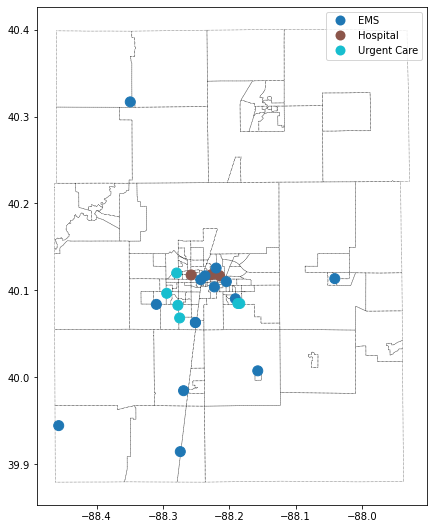

In [49]:
fig, ax = plt.subplots(figsize=(7, 10))

hc.plot(ax=ax, column='TYPE', markersize=100, legend=True, zorder=2)
cbg.boundary.plot(ax=ax, linestyle='dotted', lw=0.5, color='black', zorder=1)

In [50]:
hc = hc.to_crs(epsg=26971)
cbg = cbg.to_crs(epsg=26971)
cbg.crs

<Derived Projected CRS: EPSG:26971>
Name: NAD83 / Illinois East
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Illinois - counties of Boone; Champaign; Clark; Clay; Coles; Cook; Crawford; Cumberland; De Kalb; De Witt; Douglas; Du Page; Edgar; Edwards; Effingham; Fayette; Ford; Franklin; Gallatin; Grundy; Hamilton; Hardin; Iroquois; Jasper; Jefferson; Johnson; Kane; Kankakee; Kendall; La Salle; Lake; Lawrence; Livingston; Macon; Marion; Massac; McHenry; McLean; Moultrie; Piatt; Pope; Richland; Saline; Shelby; Vermilion; Wabash; Wayne; White; Will; Williamson.
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (meters)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [53]:
travel_time = 10
30 * 1.6 * 1000 / 60 * 10

8000.0

In [51]:
hc.geometry.buffer(8000)

0     POLYGON ((318091.878 383002.829, 318053.356 38...
1     POLYGON ((314461.377 383072.805, 314422.855 38...
2     POLYGON ((317055.291 383104.709, 317016.769 38...
3     POLYGON ((318981.581 382221.278, 318943.059 38...
4     POLYGON ((315012.101 376990.985, 314973.579 37...
5     POLYGON ((297427.513 363812.027, 297388.991 36...
6     POLYGON ((315011.685 376991.399, 314973.163 37...
7     POLYGON ((323037.769 370824.924, 322999.247 37...
8     POLYGON ((317667.772 383956.074, 317629.249 38...
9     POLYGON ((306647.051 405198.482, 306608.529 40...
10    POLYGON ((313082.427 360481.503, 313043.904 35...
11    POLYGON ((332905.397 382639.591, 332866.875 38...
12    POLYGON ((316244.612 382955.738, 316206.090 38...
13    POLYGON ((317445.679 381543.077, 317407.157 38...
14    POLYGON ((309996.706 379305.380, 309958.184 37...
15    POLYGON ((315693.003 382469.623, 315654.481 38...
16    POLYGON ((313495.975 368272.002, 313457.453 36...
17    POLYGON ((320142.619 380036.351, 320104.09

<AxesSubplot:>

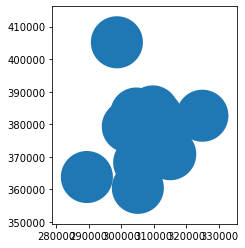

In [52]:
hc.geometry.buffer(8000).plot()